#Tiled and non-tiled 2D convolution implementation using CUDA
  Students:
 *   Capodanno Mario
 *   Grillo Valerio
 *   Lovino Emanuele

Reference:

*Programming Massively Parallel Processors: A Hands-on Approach Authors: Wen-mei W. Hwu, David B. Kirk, Izzat El Hajj Edition: Fourth Edition Publisher: Morgan Kaufmann (an imprint of Elsevier) Publication Year: 2023 ISBN: 978-0-323-91231-0*

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install nvcc4jupyter

In [ ]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp300q2wuy".


## Get GPU Device Information

In [ ]:
%%cuda
#include <iostream>

int main(int argc, char const *argv[])
{
    /// retrieve some info about the CUDA device
    int nDevices;
    cudaGetDeviceCount(&nDevices);
    for (int i = 0; i < nDevices; i++) {
      cudaDeviceProp prop;
      cudaGetDeviceProperties(&prop, i);
      printf("Device Number: %d\n", i);
      printf("  Device name: %s\n", prop.name);
      printf("  max Blocks Per MultiProcessor: %d\n", prop.maxBlocksPerMultiProcessor);
      printf("  max Threads Per MultiProcessor: %d\n", prop.maxThreadsPerMultiProcessor);
      printf("  max Threads Per Block: %d\n", prop.maxThreadsPerBlock);
      printf("  num SM: %d\n", prop.multiProcessorCount);
      printf("  num bytes sharedMem Per Block: %d\n", prop.sharedMemPerBlock);
      printf("  num bytes sharedMem Per Multiprocessor: %d\n", prop.sharedMemPerMultiprocessor);
      printf("  Memory Clock Rate (KHz): %d\n",
           prop.memoryClockRate);
      printf("  Memory Bus Width (bits): %d\n",
           prop.memoryBusWidth);
      printf("  Peak Memory Bandwidth (GB/s): %f\n\n",
           2.0*prop.memoryClockRate*(prop.memoryBusWidth/8)/1.0e6);
    }
    return 0;
}

Device Number: 0
  Device name: Tesla T4
  max Blocks Per MultiProcessor: 16
  max Threads Per MultiProcessor: 1024
  max Threads Per Block: 1024
  num SM: 40
  num bytes sharedMem Per Block: 49152
  num bytes sharedMem Per Multiprocessor: 65536
  Memory Clock Rate (KHz): 5001000
  Memory Bus Width (bits): 256
  Peak Memory Bandwidth (GB/s): 320.064000




In [ ]:
%%cuda
__global__
void convolution_2D_basic_kernel(unsigned char * in, unsigned char * mask, unsigned char * out,
                                 int maskwidth, int w, int h) {
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    int Row = blockIdx.y * blockDim.y + threadIdx.y;

    if (Col < w && Row < h) {
        int pixVal = 0;

        int N_start_col = Col - (maskwidth / 2);
        int N_start_row = Row - (maskwidth / 2);

        // Get the of the surrounding box
        for (int j = 0; j < maskwidth; ++j) {
            for (int k = 0; k < maskwidth; ++k) {

                int curRow = N_start_row + j;
                int curCol = N_start_col + k;

                // Verify we have a valid image pixel
                if (curRow > -1 && curRow < h && curCol > -1 && curCol < w) {
                    pixVal += in[curRow * w + curCol] * mask[j * maskwidth + k];
                }
            }
        }

        // Write our new pixel value out
        out[Row * w + Col] = (unsigned char)(pixVal);
    }
}


/usr/bin/ld: /usr/lib/gcc/x86_64-linux-gnu/11/../../../x86_64-linux-gnu/Scrt1.o: in function `_start':
(.text+0x1b): undefined reference to `main'
collect2: error: ld returned 1 exit status



#Naive 2D convolution.

In [ ]:
%%cuda_group_save --name "main.cu" --group "base"
#include <iostream>
#include <vector>
#include <cuda_runtime.h>
#include <cstdlib>
#include <ctime>

#define BLOCK_WIDTH 32
#define RADIUS 3
#define MASK_WIDTH (2 * RADIUS + 1)

// CUDA kernel for 2D convolution
__global__ void convolution2D(const float* N, const float* F, float* P, int r, int width, int height) {
    int outCol = blockIdx.x * blockDim.x + threadIdx.x;
    int outRow = blockIdx.y * blockDim.y + threadIdx.y;

    if (outRow < height && outCol < width) {
        float Pvalue = 0.0f;

        // Perform convolution
        for (int fRow = 0; fRow < MASK_WIDTH; fRow++) {
            for (int fCol = 0; fCol < MASK_WIDTH; fCol++) {
                int inRow = outRow - r + fRow;
                int inCol = outCol - r + fCol;
                if (inRow >= 0 && inRow < height && inCol >= 0 && inCol < width) {
                    Pvalue += F[fRow * MASK_WIDTH + fCol] * N[inRow * width + inCol];
                }
            }
        }

        // Write the result to the output
        P[outRow * width + outCol] = Pvalue;
    }
}

// Host function for managing memory and launching the kernel
void convolution2DHost(const std::vector<float>& h_N, const std::vector<float>& h_F, std::vector<float>& h_P, int r, int width, int height) {
    float* d_N;
    float* d_F;
    float* d_P;

    // Allocate device memory
    cudaMalloc((void**)&d_N, width * height * sizeof(float));
    cudaMalloc((void**)&d_F, MASK_WIDTH * MASK_WIDTH * sizeof(float));
    cudaMalloc((void**)&d_P, width * height * sizeof(float));

    // Copy data to device
    cudaMemcpy(d_N, h_N.data(), width * height * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(d_F, h_F.data(), MASK_WIDTH * MASK_WIDTH * sizeof(float), cudaMemcpyHostToDevice);

    // Define thread block and grid sizes
    dim3 dimBlock(BLOCK_WIDTH, BLOCK_WIDTH);
    dim3 dimGrid((width + dimBlock.x - 1) / dimBlock.x, (height + dimBlock.y - 1) / dimBlock.y);

    // Measure kernel execution time
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    convolution2D<<<dimGrid, dimBlock>>>(d_N, d_F, d_P, r, width, height);
    cudaEventRecord(stop);

    // Wait for the kernel to finish
    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);
    std::cout << "Convolution took " << milliseconds << " ms" << std::endl;

    // Copy result back to host
    cudaMemcpy(h_P.data(), d_P, width * height * sizeof(float), cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_N);
    cudaFree(d_F);
    cudaFree(d_P);
}

int main() {
    int width = 16384;
    int height = 16384;
    std::vector<float> h_N(width * height);
    std::vector<float> h_F(MASK_WIDTH * MASK_WIDTH);
    std::vector<float> h_P(width * height);

    // Seed the random number generator
    srand(123);

    // Initialize input data
    for (int i = 0; i < width * height; i++) {
        h_N[i] = static_cast<float>(rand());
    }

    // Initialize filter data
    for (int i = 0; i < MASK_WIDTH * MASK_WIDTH; i++) {
        h_F[i] = 1.0;
    }

    convolution2DHost(h_N, h_F, h_P, RADIUS, width, height);

    return 0;
}

In [ ]:
%cuda_group_run --group "base"

### Profiling

In [ ]:
%cuda_group_run --group "base" --profile --profiler-args "--section SpeedOfLight"

In [ ]:
%cuda_group_run --group "base" --profiler nsys --profile --profiler-args "profile --stats=true"

#Tiled 2D convolution.

In [ ]:
%%cuda_group_save --name "main.cu" --group "tile"
#include <iostream>
#include <vector>
#include <cuda_runtime.h>
#include <cstdlib>
#include <ctime>

// RULE FOR TILE DIMENSION: IN_TILE_DIM >= (2 * FILTER_RADIUS) + MASK_WIDTH
#define FILTER_RADIUS 3
#define IN_TILE_DIM 32
#define BLOCK_WIDTH IN_TILE_DIM
#define OUT_TILE_DIM ((IN_TILE_DIM) - 2*(FILTER_RADIUS))
#define MASK_WIDTH (2 * FILTER_RADIUS + 1)

__constant__ float F_c[MASK_WIDTH][MASK_WIDTH];

__global__ void convolution_tiled_2D_const_mem_kernel(float *N, float *P, int width, int height) {
    int col = blockIdx.x * OUT_TILE_DIM + threadIdx.x - FILTER_RADIUS;
    int row = blockIdx.y * OUT_TILE_DIM + threadIdx.y - FILTER_RADIUS;

    // Loading input tile
    __shared__ float N_s[IN_TILE_DIM][IN_TILE_DIM];
    if (row >= 0 && row < height && col >= 0 && col < width) {
        N_s[threadIdx.y][threadIdx.x] = N[row * width + col];
    } else {
        N_s[threadIdx.y][threadIdx.x] = 0.0;
    }
    __syncthreads();

    // Calculating output elements
    int tileCol = threadIdx.x - FILTER_RADIUS;
    int tileRow = threadIdx.y - FILTER_RADIUS;

    // Turning off the threads at the edges of the block
    if (col >= 0 && col < width && row >= 0 && row < height) {
        if (tileCol >= 0 && tileCol < OUT_TILE_DIM && tileRow >= 0 && tileRow < OUT_TILE_DIM) {
            float Pvalue = 0.0f;
            for (int fRow = 0; fRow < MASK_WIDTH; fRow++) {
                for (int fCol = 0; fCol < MASK_WIDTH; fCol++) {
                    Pvalue += F_c[fRow][fCol] * N_s[tileRow + fRow][tileCol + fCol];
                }
            }
            P[row * width + col] = Pvalue;
        }
    }
}

void convolution2DHost(const std::vector<float>& h_N, const std::vector<float>& h_F, std::vector<float>& h_P, int width, int height) {
    float* d_N;
    float* d_P;

    cudaMalloc((void**)&d_N, width * height * sizeof(float));
    cudaMalloc((void**)&d_P, width * height * sizeof(float));

    cudaMemcpy(d_N, h_N.data(), width * height * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpyToSymbol(F_c, h_F.data(), MASK_WIDTH * MASK_WIDTH * sizeof(float));

    dim3 dimBlock(BLOCK_WIDTH, BLOCK_WIDTH);
    dim3 dimGrid((width + OUT_TILE_DIM - 1) / OUT_TILE_DIM, (height + OUT_TILE_DIM - 1) / OUT_TILE_DIM);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    convolution_tiled_2D_const_mem_kernel<<<dimGrid, dimBlock>>>(d_N, d_P, width, height);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);
    float milliseconds = 0;
    cudaEventElapsedTime(&milliseconds, start, stop);

    std::cout << "Convolution took " << milliseconds << " ms" << std::endl;

    cudaMemcpy(h_P.data(), d_P, width * height * sizeof(float), cudaMemcpyDeviceToHost);

    cudaFree(d_N);
    cudaFree(d_P);
}

int main() {
    int width = 16384;
    int height = 16384;
    std::vector<float> h_N(width * height);
    std::vector<float> h_F(MASK_WIDTH * MASK_WIDTH);
    std::vector<float> h_P(width * height);

    // Seed the random number generator
    srand(123);

    // Initialize input data
    for (int i = 0; i < width * height; i++) {
        h_N[i] = static_cast<float>(rand());
    }

    // Initialize filter data
    for (int i = 0; i < MASK_WIDTH * MASK_WIDTH; i++) {
        h_F[i] = 1.0;
    }

    convolution2DHost(h_N, h_F, h_P, width, height);

    return 0;
}

In [ ]:
%cuda_group_run --group "tile"

###Profiling

In [ ]:
%cuda_group_run --group "tile" --profile --profiler-args "--section SpeedOfLight"

In [ ]:
%cuda_group_run --group "tile" --profiler nsys --profile --profiler-args "profile --stats=true"

###Plotting the results

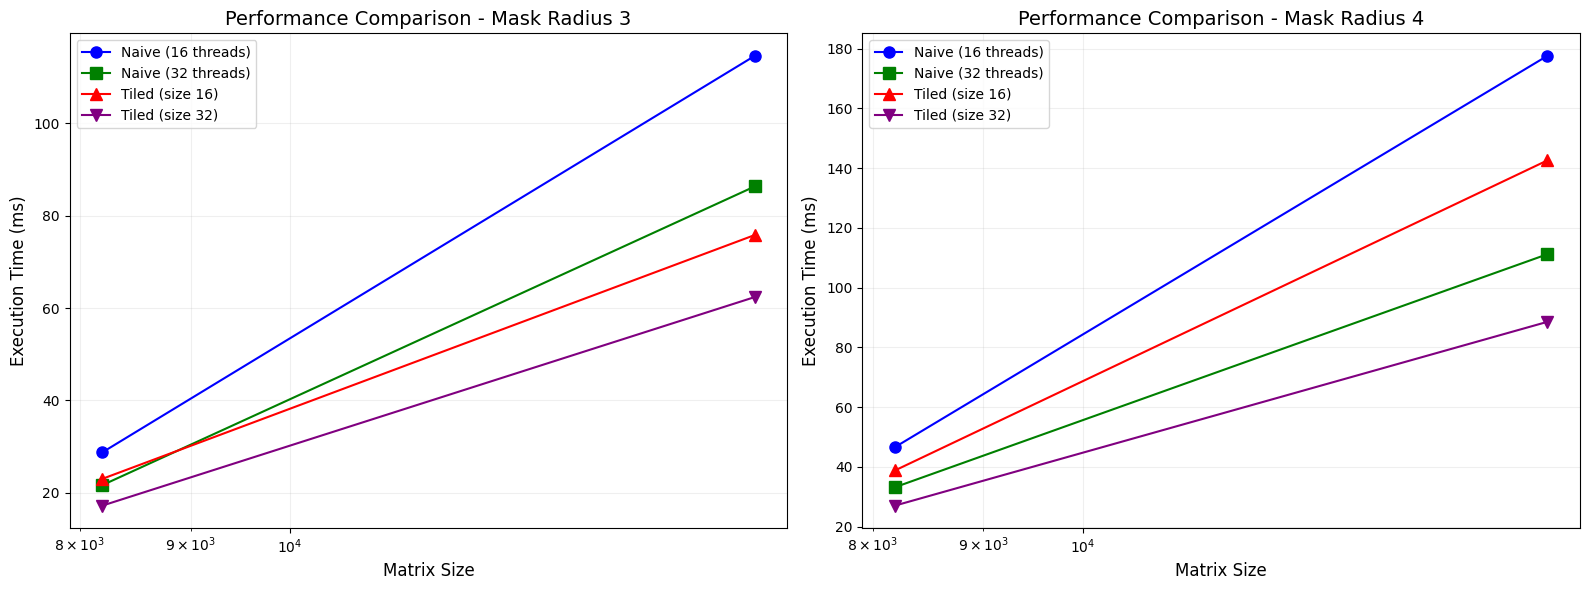

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
matrix_sizes = [8192, 16384]
thread_counts = [16, 32]

# Performance data for Mask Radius 3
naive_16_r3 = [28.77, 114.55]
naive_32_r3 = [21.68, 86.30]
tiled_16_r3 = [23.04, 75.79]
tiled_32_r3 = [17.25, 62.37]

# Performance data for Mask Radius 4
naive_16_r4 = [46.60, 177.60]
naive_32_r4 = [33.19, 111.19]
tiled_16_r4 = [38.80, 142.60]
tiled_32_r4 = [27.04, 88.56]

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Mask Radius 3
def plot_radius_data(ax, radius):
    if radius == 3:
        naive_16 = naive_16_r3
        naive_32 = naive_32_r3
        tiled_16 = tiled_16_r3
        tiled_32 = tiled_32_r3
    else:
        naive_16 = naive_16_r4
        naive_32 = naive_32_r4
        tiled_16 = tiled_16_r4
        tiled_32 = tiled_32_r4

    data = [naive_16, naive_32, tiled_16, tiled_32]
    labels = ['Naive (16 threads)', 'Naive (32 threads)', 'Tiled (size 16)', 'Tiled (size 32)']
    colors = ['blue', 'green', 'red', 'purple']
    markers = ['o', 's', '^', 'v']

    for i, (performance, label, color, marker) in enumerate(zip(data, labels, colors, markers)):
        ax.plot(matrix_sizes, performance, label=label,
                color=color, marker=marker, linestyle='-', markersize=8)

    ax.set_title(f'Performance Comparison - Mask Radius {radius}', fontsize=14)
    ax.set_xlabel('Matrix Size', fontsize=12)
    ax.set_ylabel('Execution Time (ms)', fontsize=12)
    ax.set_xscale('log')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend()

# Plot for Mask Radius 3
plot_radius_data(ax1, 3)

# Plot for Mask Radius 4
plot_radius_data(ax2, 4)

plt.tight_layout()
plt.savefig('performance_comparison_separate_radii.png', dpi=300, bbox_inches='tight')
plt.show()



---

